# Uncertainty analysis of a 2-D slice model

Possible paper titles: 

Posterior analysis of geological models/ geophysical inversions? with information theory

...with measures from information theory

...with information theoretic measures

...with information measures

...with information

Ensemble analysis...

Posterior and ensemble analysis...

(Note: reference to posterior analysis, e.g. in Tarantola paper!)

Include:

- Analysis of pynoddy models:
    - simple example of graben (because the uncertainty reduction is so counter-intuitive), 
    - and maybe more complex example of folding structure?
- Analysis of object modelling results? (i.e. the typical "Stanford channels"? but: only two outcomes, so not so meaningful... better example?)
- Analysis of posterior ensemble from geophysical inversion (Greenstone model? Other examples from Mark & Mark?)

Journal? Math. Geo? Tectonophysics (note: relevance to strucural geological models!)

Include theory: error bounds on information measures!






In [230]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [231]:
%matplotlib inline

In [242]:
# here the usual imports. If any of the imports fails, 
# make sure that pynoddy is installed
# properly, ideally with 'python setup.py develop' 
# or 'python setup.py install'
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy
reload(pynoddy)
import pynoddy.history
import pynoddy.experiment
reload(pynoddy.experiment)
rcParams.update({'font.size': 15})


## Model set-up

Subsequently, we will use a model from the "Atlas of Structural Geophysics" as an example model.

In [243]:
from pynoddy.experiment import monte_carlo
model_url = 'http://tectonique.net/asg/ch3/ch3_7/his/typeb.his'
ue = pynoddy.experiment.Experiment(url = model_url)

In [244]:
ue.change_cube_size(100)
sec = ue.get_section('y')

## BUG!!!!

Note: there is either a bug in pynoddy or in Noddy itself: but the slice plotting method fails: actually, not a slice is computed but the entire model (and the extent is also not correct!). Check with Mark in course of paper prep!

In [245]:
sec.block.shape

(100, 100, 40)

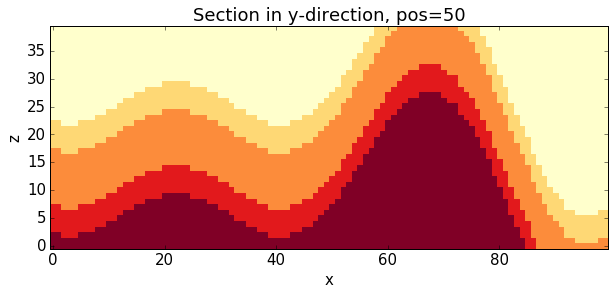

In [246]:
ue.plot_section('y')

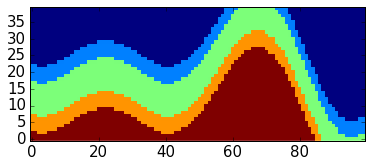

In [247]:
plt.imshow(sec.block[:,50,:].transpose(), origin = 'lower left', interpolation = 'none')

In [248]:
tmp = sec.block[:,50,:]
tmp.shape

(100, 40)

In [249]:
ue.set_random_seed(12345)

In [250]:
ue.info(events_only = True)

This model consists of 3 events:
	(1) - STRATIGRAPHY
	(2) - FOLD
	(3) - FOLD



We now define the parameter uncertainties:

In [251]:
param_stats = [{'event' : 2, 
              'parameter': 'Amplitude',
              'stdev': 100.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'Wavelength',
              'stdev': 500.0,
              'type': 'normal'},
              {'event' : 2, 
              'parameter': 'X',
              'stdev': 500.0,
              'type': 'normal'}]

ue.set_parameter_statistics(param_stats)

And, in a next step, perform the model sampling:

In [258]:
ue.set_random_seed(112358)
# perfrom random sampling
resolution = 100
sec = ue.get_section('y')

tmp = sec.block[:,50,:]
n_draws = 5000
model_sections = np.empty((n_draws, tmp.shape[0], tmp.shape[1]))

for i in range(n_draws):
    ue.random_draw()
    tmp_sec = ue.get_section('y', resolution = resolution, 
                             remove_tmp_files = True)
    model_sections[i,:,:] = tmp_sec.block[:,50,:]

Save the model data for later re-use (e.g. to extend the data set):

In [100]:
import pickle

In [260]:
f_out = open("model_sections_5k.pkl", 'w')

In [261]:
pickle.dump(model_sections, f_out)

## Calculation of cell information entropy

(Include note on: theory of entropy calculation)

(Include in this paper: estimates on error bounds?)

Here now the function to calculate entropy from a data array in general. What we will need to do later is to pass all results at a single position as a "data array" and we can then estimate the information entropy at this position.

This function already expects a sorted array as an input and then uses the (ultra-fast) switchpoint method to calculate entropy:

In [201]:
def entropy(diff_array, n_samples):
    """Determine entropy from diffarray using switchpoints"""
    switchpts = np.where(diff_array > 0 )[0] + 1
    switchpts = np.append(0, switchpts)
    switchpts = np.append(switchpts, n_samples)
    pdiff = np.diff(switchpts)
    j_prob = pdiff / float(n_samples)
    # calculate entropy
    h = 0.
    for jp in j_prob:
        h -= jp * np.log2(jp)
    return h

The algorithm works on the simple idea that we do not explicitly require the single outputs at each location, but only the relative probability values. This may not matter too much for single entropy estimates (uni-variate), but it will matter a lot for multivariate cases, because we do not need to check all possible outcomes! Note that all outcomes with zero probability are simply not considered in the sorting algorithm (and they do not play any role in the calculation of the entropy, anyway), and that's exactly what we want to have!

In [328]:
# sort data (axis = 0: sort along model results!)
mssort = np.sort(model_sections, axis = 0)
# create difference matrix
mssort_diff = mssort[1:,:,:] - mssort[:-1,:,:]

n_samples = model_sections.shape[0]
# and now: for all!
h = np.empty_like(mssub[0,:,:])
for i in range(100):
    for j in range(40):
        h[i,j] = entropy(mssort_diff[:,i,j], n_samples)
h[50,30]

1.5373957598393617

We now visualise the cell information entropy, shown in Fig. (). We can here clearly identify uncertain regions within this model section. It is interesting to note that we can mostly still identify the distinct layer boundaries in the fuzzy areas of uncertainty around their borders (note: highlight in Figure!). However, additional aspects of uncertainty are now introduced: (a) the uncertainty about the x-position of the folds (see parameters: event 2, parameter x) is now clearly visible, and (b) uncertianties now seem to concentrate on the fold hinges. However, this is not so clear in the left part of the model, where the fold hing seems to be the least uncertain part. (check why: is this where the fold is actually fixed (even though still uncertain). My current interpretation: the fold location is fixed somewhere near this point, and so the wavelength uncertainty does not play a significant role. Furthermore, the fold is quite "open" at this position (i.e.: low angle between hinges) and therefore lateral shifts do not play a significant role.

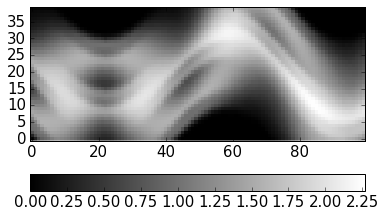

In [329]:
plt.imshow(h.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')

Here again an example of single models (adjust to visualise and probably include something like a "table plot" of multiple images for a paper!):

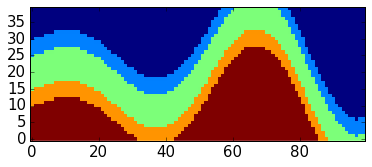

In [278]:
plt.imshow(mssub[70,:,:].transpose(), origin = 'lower left', interpolation = 'none')

And here the "mean" lithologies (note: not really a distinct meaning, simply showing the average litho ids - could be somehow interpreted as characteristic functions, though...).

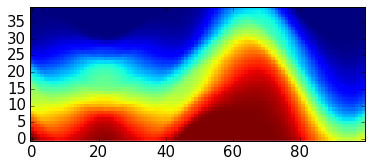

In [279]:
plt.imshow(np.mean(mssub, axis = 0).transpose(), origin = 'lower left', interpolation = 'none')

And here a bit more meaningful: the analysis of single layer probabilities:

In [324]:
# step 1: estimate probabilities (note: unfortunate workaround with ones multiplication,
# there may be a better way, but this is somehow a recurring problem of implicit
# array flattening in numpy)
litho_id = 4
prob = np.sum(np.ones_like(mssub) * (mssub == litho_id), axis = 0) / float(n_samples)

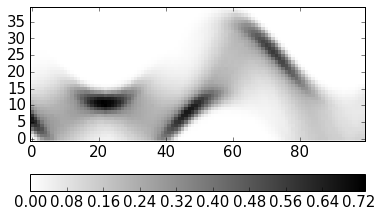

In [325]:
plt.imshow(prob.transpose(), 
           origin = 'lower left', 
           interpolation = 'none', 
           cmap = 'gray_r')
plt.colorbar(orientation = 'horizontal')

Idea: also include a "new" consideration: where to collect information to reduce uncertainty of a single layer? Could be identified by reducing layer fuzziness, for example!

Or: what are most likely positions/ locations of a specific unit, given collected information?




## Analysis of multivariate condtional entropy

Later also:

- "opposite" question, i.e.: if we would like to resolve uncertainty in a specific region: where to look best?
- "complete" uncertainty (i.e.: joint entropy!)
- greedy search for best spots for uncertainty reduction, simple (cell-wise), complex (related to potential drilling positions)
- further ideas for "greedy search" to reduce uncertainties in a specific "search region" (i.e.: expected location of a deposit, etc.):
    - start with cell with highest (multivariate) mutual information
    - rank cells with highest I due to their own mutual information with other cells, which are not part of a defined "search region"
- for simple, cell-wise: describe similarity to mapping! Maybe even a field example with data from Belgium? But this is still one or two MSc theses away...)

For the joint entropy analysis, we now use the new lexicographic (correct term?) sorting algorithm, implemented in the module hspace:

In [330]:
sys.path.append("/Users/flow/git/mutual_information/")

In [352]:
import hspace
reload(hspace)

<module 'hspace' from '/Users/flow/git/mutual_information/hspace.py'>

Problem now: in hspace module, a single location information is required. Try to adapt?

In [353]:
locs = np.array([1,2,3])
locs.shape

(3,)

In [354]:
locs = np.array([[1,1],[1,2],[1,3]])
locs.shape

(3, 2)

In [339]:
models_sub = model_sections[:10,:,:]

In [351]:
joint_units = []
for entry in models_sub:
    joint_val = ""
    for i, loc in enumerate(locs):
        joint_val += "%d" % entry[loc[0], loc[1]]
    joint_units.append(joint_val)
print joint_units

['555', '555', '544', '554', '444', '444', '555', '544', '555', '555']


In [358]:
hspace.joint_entropy(model_sections, locs, n_samples)

1.7990750648942482

In [443]:
# now: define position of "drill":
n = 10
drill_i = [60] * n
drill_j = range(39,39-n,-1)
drill_locs = zip(drill_i, drill_j)

In [444]:
# determine joint entropy of drill_locs:
h_joint_drill = hspace.joint_entropy(model_sections, drill_locs, n_samples)

In [445]:
# check with arbitrary additional position:
locs = drill_locs + [[50, 20]]
print locs
h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
print h_joint_drill
print h_joint_loc
print h_joint_loc - h_joint_drill
print h[50,30]

[(60, 39), (60, 38), (60, 37), (60, 36), (60, 35), (60, 34), (60, 33), (60, 32), (60, 31), (60, 30), [50, 20]]
4.70788509644
5.20006290337
0.492177806936
1.53739575984


In [483]:
# Determine max value of initital entropies for colorbar scaling
h_max = np.max(h)
print h_max
n_max = int(np.ceil(2 ** h_max))
print n_max
print np.log2(n_max)

2.26920150856
5
2.32192809489


In [456]:
pwd

u'/Users/flow/git/pynoddy/docs/notebooks'

In [465]:
# Import Viridis colorscale
import colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.register_cmap(name='magma', cmap=cmaps.magma)
plt.set_cmap(cmaps.viridis)

Try own "entropy colormap":

In [446]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        locs = drill_locs + [[i,j]]
        # determine joint entropy
        h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

In [536]:
import simple_2D_example
from simple_2D_example import entropy_colormap
reload(simple_2D_example)

<module 'simple_2D_example' from '/Users/flow/git/mutual_information/simple_2D_example.py'>

In [537]:
ecmap = simple_2D_example.entropy_colormap(h_max);

1.0 5 0.0
2.0 5 0.430676558073
3.0 5 0.682606194486
4.0 5 0.861353116147
5.0 5 1.0


(0, 39)

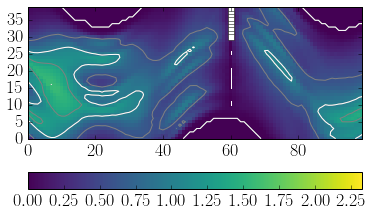

In [561]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'viridis', interpolation = 'none', vmax=np.log2(n_max+0.02))
plt.colorbar(orientation = 'horizontal')
# half-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, .5))
plt.contour(h_cond_drill.transpose(), contour_levels, colors = 'gray')
# superpose 1-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, 1.))
plt.contour(h_cond_drill.transpose(), contour_levels, colors = 'white')

plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

For comparison again: the entropy of the initial model:

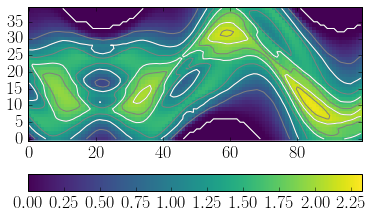

In [558]:
plt.imshow(h.transpose(), origin = 'lower left',
          cmap = 'viridis', interpolation = 'none', vmax=np.log2(n_max+0.02))
plt.colorbar(orientation = 'horizontal')
# half-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, .5))
plt.contour(h.transpose(), contour_levels, colors = 'gray')
# superpose 1-step contour lines
contour_levels = np.log2(np.arange(1., n_max + 0.001, 1.))
plt.contour(h.transpose(), contour_levels, colors = 'white')



And the difference, for clarity:

(0, 39)

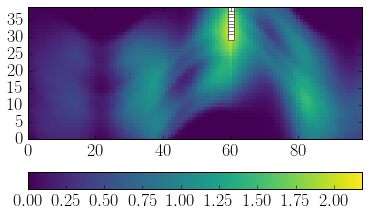

In [479]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'viridis', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,99])
plt.ylim([0,39])

Clearly, the highset reduction is in the area around the borehole, but interestingly, the uncertianty in other areas is also reduced! Note specifically the reduction of uncertainties in the two neighbouring fold hinges.

Let's check some other positions (and drilling "depths"):

In [381]:
# define position of "drill":
n = 10
drill_i = [20] * n
drill_j = range(39,39-n,-1)
drill_locs = zip(drill_i, drill_j)
# determine joint entropy of drill_locs:
h_joint_drill = hspace.joint_entropy(model_sections, drill_locs, n_samples)

We also just include one timing step to estimate the approximate simualtion time:

In [382]:
%%timeit
locs = drill_locs + [[50,20]]
h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)

10 loops, best of 3: 47.6 ms per loop


In [385]:
# esimated total time:
ttime = 100 * 40 * 0.0476
print("Estimated total time: %.3f seconds or %.3f minutes" % (ttime, ttime/60.))

Estimated total time: 190.400 seconds or 3.173 minutes


In [386]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        locs = drill_locs + [[i,j]]
        # determine joint entropy
        h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

In [438]:
# store results
f_out = open("h_cond_drill_i20_10.pkl", 'w')
pickle.dump(h_cond_drill, f_out)
f_out.close()

(0, 40)

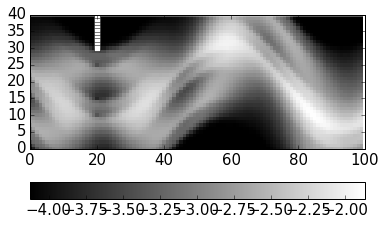

In [407]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

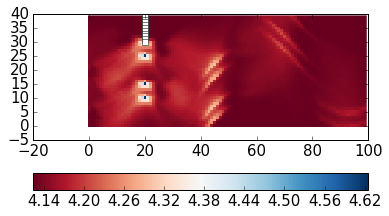

In [402]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

Intersting! Only a local reduction around the drilling position, however: extending to the deeper layers, as well! Why?

Drill deeper:

In [408]:
# define position of "drill":
n = 30
drill_i = [20] * n
drill_j = range(39,39-n,-1)
drill_locs = zip(drill_i, drill_j)
# determine joint entropy of drill_locs:
h_joint_drill = hspace.joint_entropy(model_sections, drill_locs, n_samples)

In [409]:
%%timeit
locs = drill_locs + [[50,20]]
h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)

10 loops, best of 3: 130 ms per loop


In [410]:
# esimated total time:
ttime = 100 * 40 * 0.130
print("Estimated total time: %.3f seconds or %.3f minutes" % (ttime, ttime/60.))

Estimated total time: 520.000 seconds or 8.667 minutes


In [411]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        locs = drill_locs + [[i,j]]
        # determine joint entropy
        h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 40)

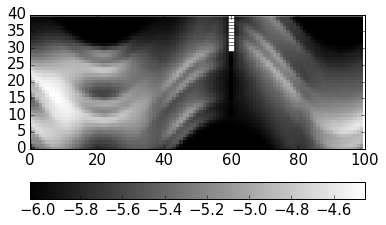

In [439]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

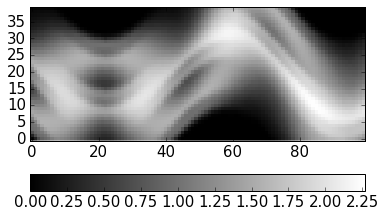

In [413]:
plt.imshow(h.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')

(0, 40)

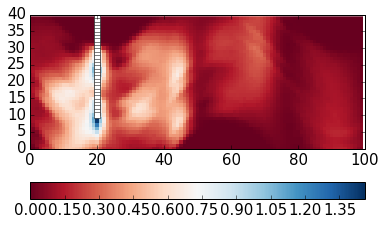

In [414]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

In [415]:
# define position of "drill":
n = 30
drill_i = [60] * n
drill_j = range(39,39-n,-1)
drill_locs = zip(drill_i, drill_j)
# determine joint entropy of drill_locs:
h_joint_drill = hspace.joint_entropy(model_sections, drill_locs, n_samples)

In [417]:
%%timeit
locs = drill_locs + [[50,20]]
h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)

10 loops, best of 3: 129 ms per loop


In [418]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        locs = drill_locs + [[i,j]]
        # determine joint entropy
        h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 40)

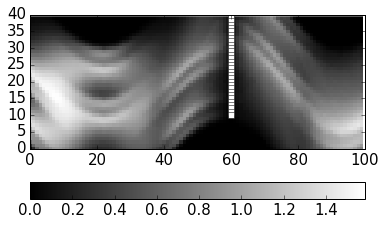

In [419]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

(0, 40)

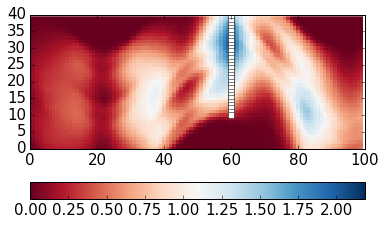

In [420]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

Interesting! And now both combined:

In [421]:
# define position of "drill":
n = 30
drill_i = [60] * n + [20] * n
drill_j = range(39,39-n,-1) + range(39,39-n,-1)
drill_locs = zip(drill_i, drill_j)
# determine joint entropy of drill_locs:
h_joint_drill = hspace.joint_entropy(model_sections, drill_locs, n_samples)

In [422]:
%%timeit
locs = drill_locs + [[50,20]]
h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)

1 loops, best of 3: 249 ms per loop


In [423]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        locs = drill_locs + [[i,j]]
        # determine joint entropy
        h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

(0, 40)

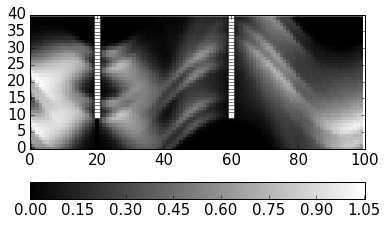

In [424]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

(0, 40)

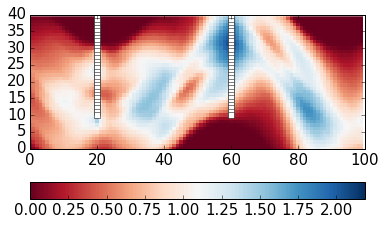

In [425]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

We can see that now only a part on the left remains with significant uncertainties. So, let's "drill" into this, as well:

In [426]:
# define position of "drill":
n = 30
drill_i = [60] * n + [20] * n + [5] * n
drill_j = range(39,39-n,-1) + range(39,39-n,-1) + range(39,39-n,-1)
drill_locs = zip(drill_i, drill_j)
# determine joint entropy of drill_locs:
h_joint_drill = hspace.joint_entropy(model_sections, drill_locs, n_samples)

In [427]:
%%timeit
locs = drill_locs + [[50,20]]
h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)

1 loops, best of 3: 375 ms per loop


In [428]:
# generate conditional entropies for entire section:
h_cond_drill = np.zeros_like(h)
for i in range(100):
    for j in range(40):
        # add position to locations
        locs = drill_locs + [[i,j]]
        # determine joint entropy
        h_joint_loc = hspace.joint_entropy(model_sections, locs, n_samples)
        # subtract joint entropy of drill locs to obtain conditional entropy
        h_cond_drill[i,j] = h_joint_loc - h_joint_drill

In [431]:
# store results
f_out = open("h_cond_drill_i62_20_5_30.pkl", 'w')
pickle.dump(h_cond_drill, f_out)
f_out.close()

Additional idea to speed up computation (especially for higher multivariate examples): do not estimate value at locations where conditional entropy of subset (i.e.: often previously calculated)! (Check: theoretical reason/ justification!)

(0, 40)

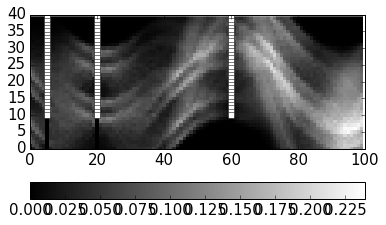

In [429]:
plt.imshow(h_cond_drill.transpose(), origin = 'lower left',
          cmap = 'gray', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])

(0, 40)

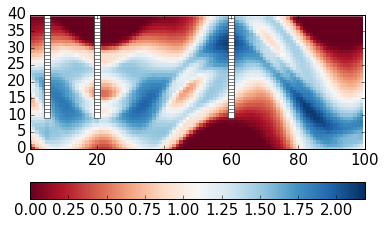

In [432]:
plt.imshow((h - h_cond_drill).transpose(), origin = 'lower left',
          cmap = 'RdBu', interpolation = 'none')
plt.colorbar(orientation = 'horizontal')
# plot drilling positions above it:
dp = np.array(drill_locs).transpose()
plt.plot(dp[0], dp[1], 'ws')
plt.xlim([0,100])
plt.ylim([0,40])